In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, \
    GradientBoostingClassifier, RandomForestClassifier

random_state = 44

In [290]:
df = pd.read_csv("features.csv", index_col=0)
df.dropna(inplace=True)
X = df.drop(columns=['malign', 'patient_name'])
y = df['malign']


In [291]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

In [292]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)

In [293]:
tree = DecisionTreeClassifier(random_state=random_state, min_samples_split=100)
ada = AdaBoostClassifier(random_state=random_state)
bagging = BaggingClassifier(random_state=random_state)
boost = GradientBoostingClassifier(random_state=random_state)
forest = RandomForestClassifier(random_state=random_state, min_samples_split=4)

clfs = [tree, ada, bagging, boost, forest]
for clf in clfs:
    clf = clf.fit(X_train, y_train)


In [294]:
clfs_names = ['DecisionTreeClassifier', 'AdaBoostClassifier', 'BaggingClassifier', \
    'GradientBoostingClassifier', 'RandomForestClassifier']

In [295]:
# print("Tree parameters: ", clf.get_params())
# print("\n\nTree depth: ", clf.get_depth())

In [296]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
y_pred = clf.predict(X_train)

results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': []}
ys_pred = {}

for clf, name in zip(clfs, clfs_names):
    y_pred = clf.predict(X_train)
    ys_pred[name] = y_pred
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_train, y_pred))
    results['F1 score'].append(f1_score(y_train, y_pred))
    results['Precision'].append(precision_score(y_train, y_pred))
    results['Recall'].append(recall_score(y_train, y_pred))

results_df = pd.DataFrame(results)
print("Performance on TRAINING set")
results_df.head(len(clfs_names))

Performance on TRAINING set


,Name,Accuracy,F1 score,Precision,Recall
0,DecisionTreeClassifier,0.881262,0.747036,0.926471,0.625828
1,AdaBoostClassifier,0.908163,0.826620,0.877323,0.781457
2,BaggingClassifier,0.983302,0.969492,0.993056,0.947020
3,GradientBoostingClassifier,0.982375,0.967632,0.996491,0.940397
4,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000


In [297]:
y_pred = clf.predict(X_val)

results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': []}
ys_pred = {}

for clf, name in zip(clfs, clfs_names):
    y_pred = clf.predict(X_val)
    ys_pred[name] = y_pred
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_val, y_pred))
    results['F1 score'].append(f1_score(y_val, y_pred))
    results['Precision'].append(precision_score(y_val, y_pred))
    results['Recall'].append(recall_score(y_val, y_pred))

results_df = pd.DataFrame(results)
print("Performance on VALIDATION set")
results_df.head(len(clfs_names))

Performance on VALIDATION set


,Name,Accuracy,F1 score,Precision,Recall
0,DecisionTreeClassifier,0.777778,0.500000,0.625000,0.416667
1,AdaBoostClassifier,0.837037,0.645161,0.769231,0.555556
2,BaggingClassifier,0.829630,0.581818,0.842105,0.444444
3,GradientBoostingClassifier,0.866667,0.709677,0.846154,0.611111
4,RandomForestClassifier,0.859259,0.641509,1.000000,0.472222


# Macierze błędów

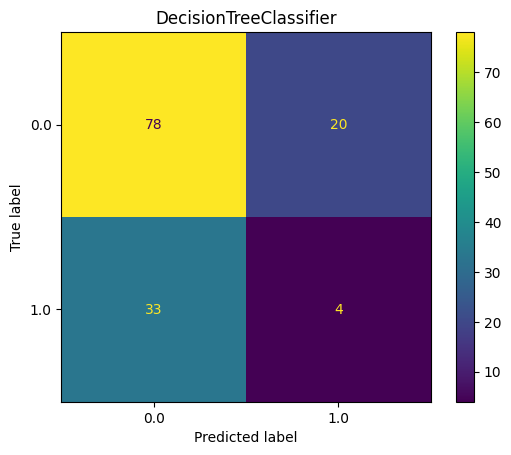

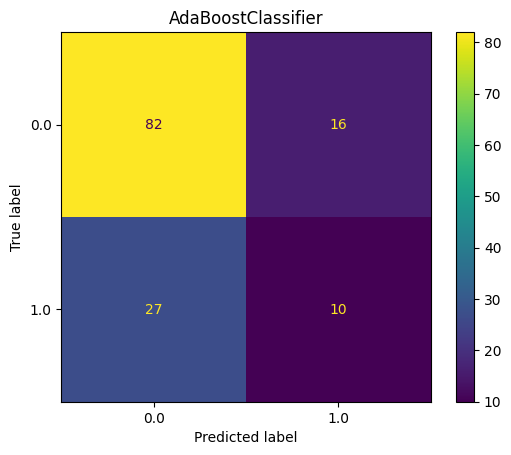

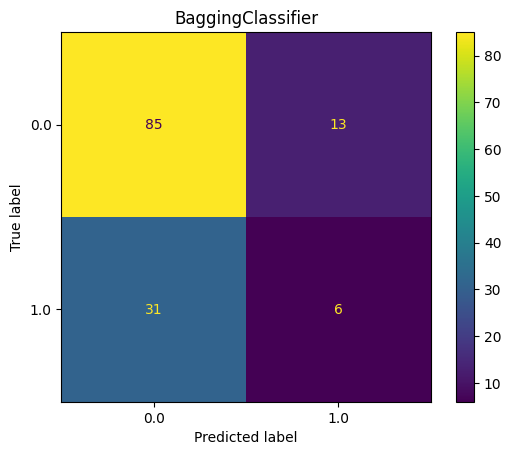

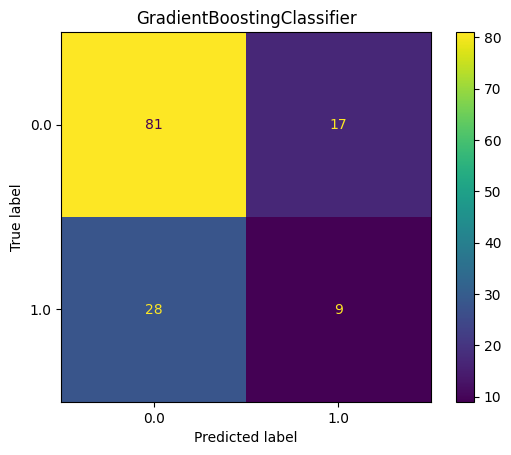

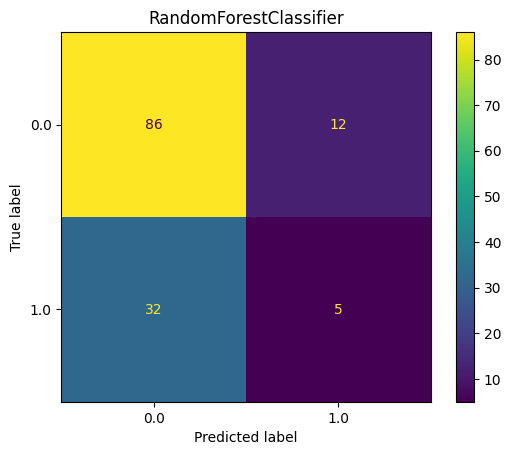

In [298]:
for clf, name in zip(clfs, clfs_names):
    y_pred = ys_pred[name]
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.title(f"{name}")
    plt.show()

# Analiza krzywa charakterystyki działania odbiornika (ROC)

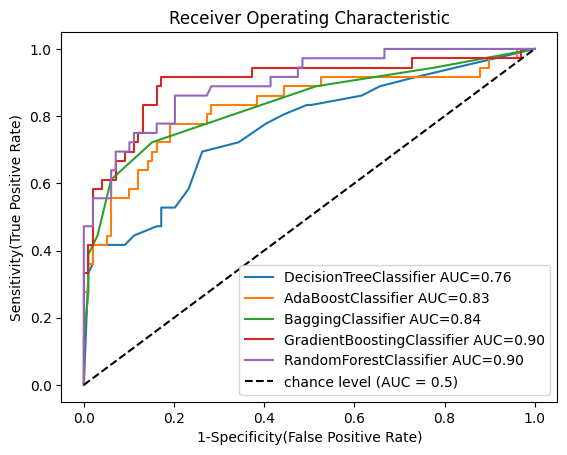

In [299]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
ys_pred_proba = {}
clfs_thresholds = {}
for clf, name in zip(clfs, clfs_names):
    y_pred_proba = clf.predict_proba(X_val)
    y_pred_proba = y_pred_proba[:, 1]
    ys_pred_proba[name] = y_pred_proba

    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    # data = {'fpr': fpr, 'trp': tpr, 'thresholds': thresholds}
    # df = pd.DataFrame(data)
    # df.head(100)
    roc_auc = auc(fpr, tpr)
    clfs_thresholds[name] = thresholds
    # display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)

    # RocCurveDisplay.from_predictions(
    #     y_val,
    #     y_pred,
    #     name=f"My threshold",
    #     color="darkorange",
    # )
    plt.plot(fpr,tpr,label=f"{name} AUC={roc_auc:.2f}"+str())

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

In [300]:
# data = {'fpr': fpr, 'trp': tpr, 'thresholds': thresholds}
# df = pd.DataFrame(data)
# df.head(len(fpr))

In [301]:
best_thresholds = {}
for clf, name in zip(clfs, clfs_names):
    best_f1 = 0
    best_th = None
    for threshold in clfs_thresholds[name]:
        y_pred = ys_pred_proba[name] > threshold
        f1 = f1_score(y_val, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_th = threshold
    best_thresholds[name] = best_th
    

In [302]:
results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': [], 'Best Th.': []}

for clf, name in zip(clfs, clfs_names):
    best_th = best_thresholds[name]
    y_pred = ys_pred_proba[name] > best_th
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_val, y_pred))
    results['F1 score'].append(f1_score(y_val, y_pred))
    results['Precision'].append(precision_score(y_val, y_pred))
    results['Recall'].append(recall_score(y_val, y_pred))
    results['Best Th.'].append(best_th)

results_df = pd.DataFrame(results)
print("Results after threshold adjustment on VALIDATION")
results_df.head(len(clfs_names))

Results after threshold adjustment on VALIDATION


,Name,Accuracy,F1 score,Precision,Recall,Best Th.
0,DecisionTreeClassifier,0.725926,0.574713,0.490196,0.694444,0.125000
1,AdaBoostClassifier,0.792593,0.658537,0.586957,0.750000,0.494180
2,BaggingClassifier,0.851852,0.687500,0.785714,0.611111,0.400000
3,GradientBoostingClassifier,0.851852,0.761905,0.666667,0.888889,0.200962
4,RandomForestClassifier,0.851852,0.722222,0.722222,0.722222,0.359833


In [303]:
results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': [], 'Best Th.': []}
ys_pred_test_proba = {}

for clf, name in zip(clfs, clfs_names):
    best_th = best_thresholds[name]
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    ys_pred_test_proba[name] = y_pred_proba
    y_pred = y_pred_proba > best_th
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['F1 score'].append(f1_score(y_test, y_pred))
    results['Precision'].append(precision_score(y_test, y_pred))
    results['Recall'].append(recall_score(y_test, y_pred))
    results['Best Th.'].append(best_th)

results_df = pd.DataFrame(results)
print("Results after threshold adjustment on TEST data")
results_df.head(len(clfs_names))

Results after threshold adjustment on TEST data


,Name,Accuracy,F1 score,Precision,Recall,Best Th.
0,DecisionTreeClassifier,0.733333,0.581395,0.510204,0.675676,0.125000
1,AdaBoostClassifier,0.837037,0.710526,0.692308,0.729730,0.494180
2,BaggingClassifier,0.859259,0.698413,0.846154,0.594595,0.400000
3,GradientBoostingClassifier,0.837037,0.725000,0.674419,0.783784,0.200962
4,RandomForestClassifier,0.866667,0.750000,0.771429,0.729730,0.359833


In [304]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
y_pred = clf.predict(X_test)

results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': []}
ys_pred = {}

for clf, name in zip(clfs, clfs_names):
    y_pred = clf.predict(X_test)
    ys_pred[name] = y_pred
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['F1 score'].append(f1_score(y_test, y_pred))
    results['Precision'].append(precision_score(y_test, y_pred))
    results['Recall'].append(recall_score(y_test, y_pred))

results_df = pd.DataFrame(results)
print("Results WITHOUT threshold adjustment on TEST data")
results_df.head(len(clfs_names))

Results WITHOUT threshold adjustment on TEST data


,Name,Accuracy,F1 score,Precision,Recall
0,DecisionTreeClassifier,0.748148,0.392857,0.578947,0.297297
1,AdaBoostClassifier,0.859259,0.698413,0.846154,0.594595
2,BaggingClassifier,0.844444,0.603774,1.000000,0.432432
3,GradientBoostingClassifier,0.866667,0.718750,0.851852,0.621622
4,RandomForestClassifier,0.859259,0.677966,0.909091,0.540541


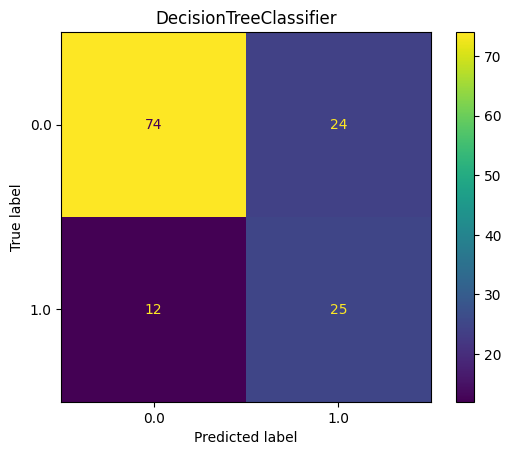

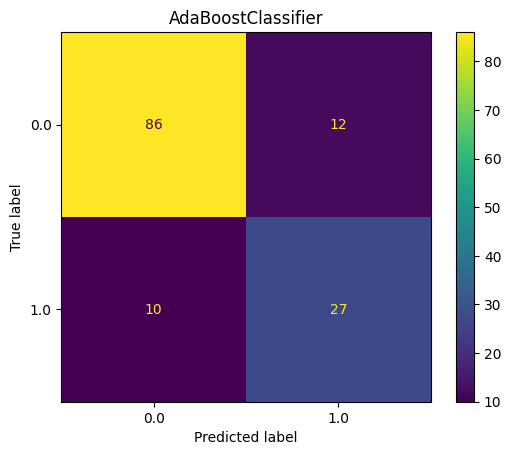

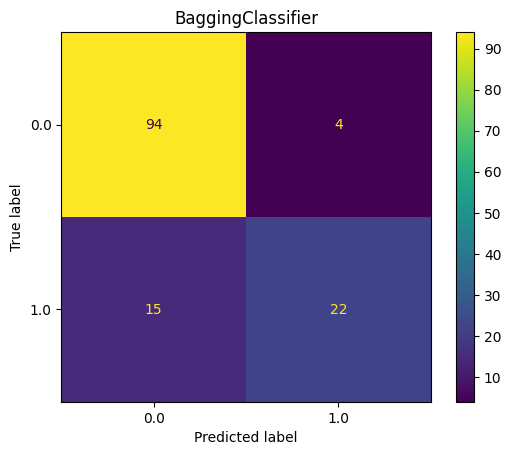

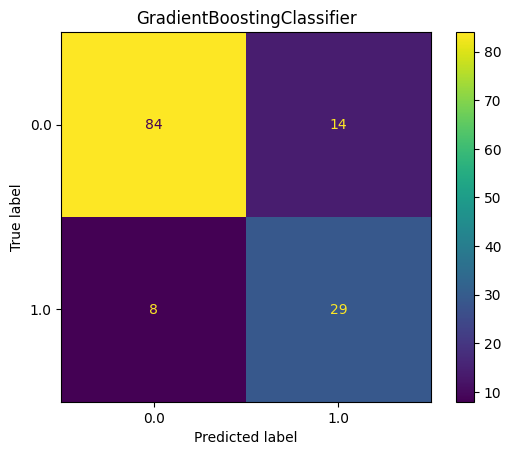

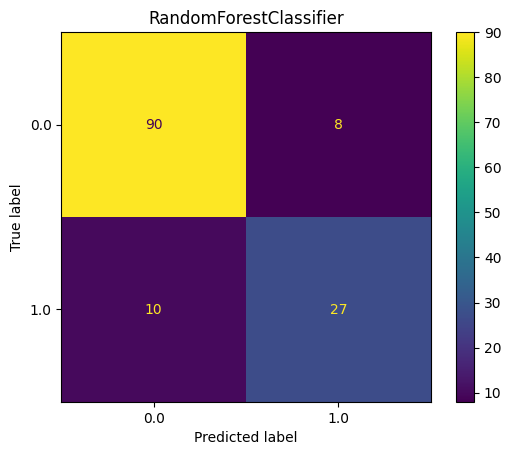

In [305]:
for clf, name in zip(clfs, clfs_names):
    best_th = best_thresholds[name]
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    ys_pred_test_proba[name] = y_pred_proba
    y_pred = y_pred_proba > best_th
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.title(f"{name}")
    plt.show()